# Анализ базы данных stackoverflow

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [4]:
# напишите запрос
query = '''
SELECT EXTRACT(MONTH FROM creation_date::date) AS month_date,
       SUM(views_count)  AS total_views 

FROM stackoverflow.posts
GROUP BY EXTRACT(MONTH FROM creation_date::date)
ORDER BY total_views DESC

'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,month_date,total_views
0,9.0,452928568
1,10.0,365400138
2,11.0,221759651
3,12.0,197792841
4,8.0,131367083
5,7.0,669895


**Наибольшее количество просмотров наблюдается в сентябре, после чего идёт спад до декабря**

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [5]:
# напишите запрос
query = '''
SELECT users.display_name,  COUNT(DISTINCT(users.id)) AS cnt
              FROM stackoverflow.users 
              JOIN stackoverflow.posts ON users.id = posts.user_id
              JOIN stackoverflow.post_types ON posts.post_type_id = post_types.id
              
              WHERE post_types.type = 'Answer' AND (posts.creation_date::date <= (users.creation_date + INTERVAL '30 days'))
              
              GROUP BY users.display_name
              HAVING COUNT(posts.id) > 100
              ORDER BY users.display_name ASC
              
              






'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,display_name,cnt
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


**Даже на первый взгляд слишком много "непонятных" ников**

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [6]:
# напишите запрос
query = '''
WITH users_sep AS (SELECT DISTINCT(users.id) AS id
                   FROM stackoverflow.posts
                   JOIN stackoverflow.users ON users.id = posts.user_id
                   WHERE EXTRACT(YEAR FROM users.creation_date::date) = 2008 AND EXTRACT(MONTH FROM users.creation_date::date) = 9 AND EXTRACT(MONTH FROM posts.creation_date::date) = 12 
 
                  )

SELECT DATE_TRUNC('month', creation_date) AS month_date,
       COUNT(posts.id)  AS count_posts 

FROM stackoverflow.posts
INNER JOIN users_sep on posts.user_id = users_sep.id
GROUP BY month_date
ORDER BY month_date DESC

'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,month_date,count_posts
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


**Данных за август не должно быть. Вероятно были ошибки в дате постов**

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [7]:
# напишите запрос
query = '''
SELECT user_id, creation_date, views_count, SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id, creation_date


'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [8]:
# напишите запрос
query = '''
WITH av AS (
                SELECT p.user_id as u_id,
                       DATE_TRUNC('day', p.creation_date) AS dy,
                       COUNT(p.id) AS cnt_pst
                FROM stackoverflow.posts AS p
                WHERE (p.creation_date BETWEEN '2008-08-01' AND '2008-08-31 23:59:59.999') AND
                      p.user_id IN     (SELECT id
                                 FROM            (SELECT p.user_id AS id, COUNT(p.id) as count_posts
                                                  FROM stackoverflow.posts AS p
                                                  WHERE p.creation_date BETWEEN '2008-08-01' AND '2008-08-31 23:59:59.999' 
                                                  GROUP BY p.user_id
                                                 ) AS scores
                                 WHERE scores.count_posts > 120 
                                 )
 
                GROUP BY dy, p.user_id           
            )          
               
SELECT   u_id, AVG(cnt_pst) AS avg_pst
FROM av
GROUP BY u_id
ORDER BY avg_pst
               
               
      
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,u_id,avg_pst
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


In [9]:
query = '''
WITH av AS (
                SELECT p.user_id as u_id,
                       DATE_TRUNC('day', p.creation_date) AS dy,
                       COUNT(p.id) AS cnt_pst
                FROM stackoverflow.posts AS p
                WHERE (DATE_TRUNC('month',p.creation_date) BETWEEN '2008-08-01' AND '2008-08-31') AND
                      p.user_id IN     (SELECT id
                                 FROM            (SELECT p.user_id AS id, COUNT(p.id) as count_posts
                                                  FROM stackoverflow.posts AS p
                                                  WHERE DATE_TRUNC('month',p.creation_date) BETWEEN '2008-08-01' AND '2008-08-31' 
                                                  GROUP BY p.user_id
                                                 ) AS scores
                                 WHERE scores.count_posts > 120 
                                 )
 
                GROUP BY dy, p.user_id           
            )          
               
SELECT   u_id, AVG(cnt_pst) AS avg_pst
FROM av
GROUP BY u_id
ORDER BY avg_pst
               
               
      
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,u_id,avg_pst
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [10]:
# напишите запрос
query = '''
WITH scores AS (  
                SELECT p.user_id, COUNT(DISTINCT(EXTRACT(DAY FROM creation_date))) AS cnt_day
                FROM stackoverflow.posts AS p
                WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
                GROUP BY p.user_id
                
                )
                
SELECT ROUND(AVG(cnt_day))
FROM scores
WHERE cnt_day > 0

                
                
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,round
0,2.0


Получается 2 активных дня в неделю. Это 2 поста в неделю от человека. Не такой плохой результат, учитывая, что на таких платформах не так часто пишут посты

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [11]:
# напишите запрос TO_CHAR(creation_date, 'Month')
query = '''
SELECT p.user_id,
       creation_date,
       LAG(TO_CHAR(creation_date, 'Month'),2) OVER (PARTITION BY user_id ORDER BY creation_date) AS second_last_month
FROM stackoverflow.posts AS p
ORDER BY p.user_id;
'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [12]:
query = '''
WITH profile AS 
    (SELECT user_id,
            cohort_dt,
            COUNT(*)   OVER (PARTITION BY cohort_dt) AS cohort_users_cnt
            
     FROM (SELECT DISTINCT(user_id) AS user_id,
                  FIRST_VALUE(session_date) OVER(PARTITION BY user_id) AS cohort_dt

            FROM         (SELECT user_id,
                                 DATE_TRUNC('month', creation_date) AS session_date
                          FROM stackoverflow.posts
                          GROUP BY 1,2) AS f) AS fc
            
    ),
            
sessions AS 
    (SELECT user_id,
            DATE_TRUNC('month', creation_date) AS session_date
     FROM stackoverflow.posts
     GROUP BY 1,2        
    )   
    
SELECT p.cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4  
'''   
    
df = pd.read_sql_query(query, con=engine)
df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

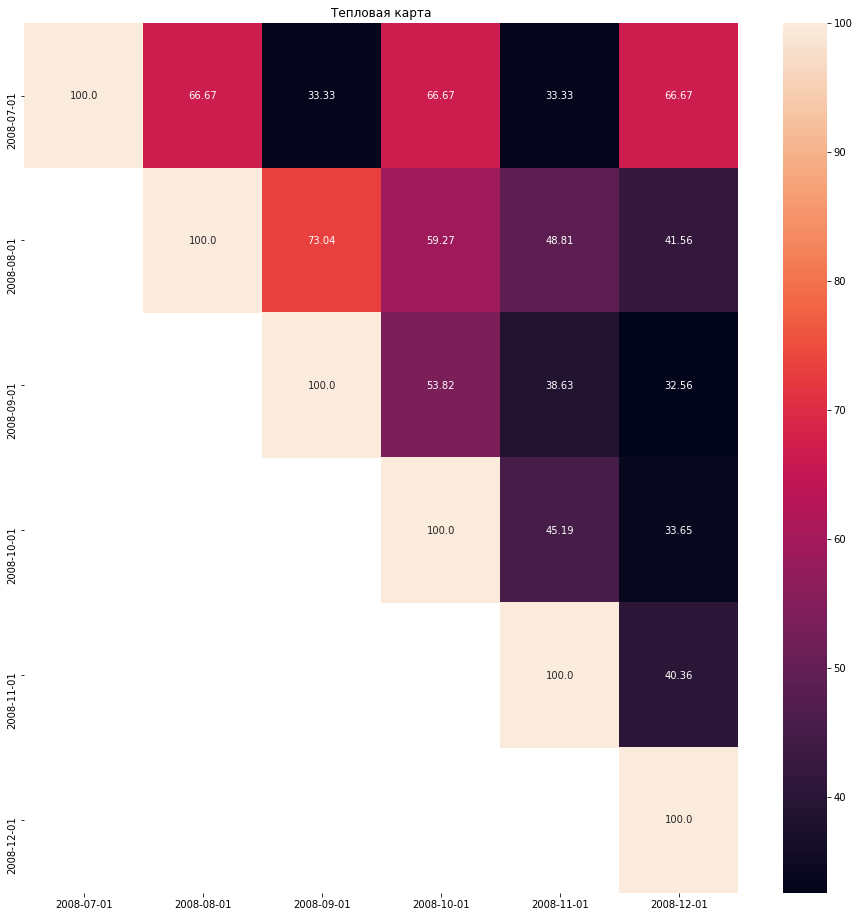

In [13]:
# постройте тепловую карту Retention Rate
# создаём сводную таблицу с результатами
retention = df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()

**За первый месяц больше всего значение Retention Rate в июльской когорте, дальше идет спад, меньше всего значение в когорте ноября. За второй месяц четкой тенденции нет, но значение везде меньше, чем в первый месяц**

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [14]:
# напишите запрос
query = '''
WITH count_p AS (
                 SELECT EXTRACT(MONTH FROM creation_date) AS creation_month,
                        COUNT(p.id) AS posts_count
                 FROM stackoverflow.posts AS p
                 WHERE creation_date BETWEEN '2008-09-01' AND '2008-12-31'
                 GROUP BY EXTRACT(MONTH FROM creation_date)
                 
                 )
SELECT *,
       ROUND(((posts_count::numeric / LAG(posts_count, 1, posts_count) OVER (ORDER BY creation_month)) - 1) * 100) AS percentage
FROM count_p





'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,creation_month,posts_count,percentage
0,9.0,70371,0.0
1,10.0,63102,-10.0
2,11.0,46975,-26.0
3,12.0,44592,-5.0


Постройте круговую диаграмму с количеством постов по месяцам.

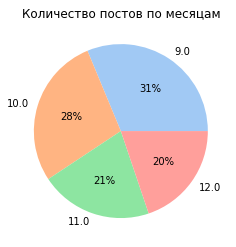

In [15]:
# постройте круговую диаграмму с количеством постов по месяцам
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = df['posts_count']
labels = df['creation_month']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[ 0:5 ]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Количество постов по месяцам")
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [16]:
# напишите запрос
query = '''
WITH count_p AS (
                 SELECT user_id,
                        COUNT(p.id) AS posts_count
                 FROM stackoverflow.posts AS p
                 GROUP BY user_id
                 
                 )
SELECT user_id
FROM count_p
WHERE count_p.posts_count IN (SELECT MAX(count_p.posts_count)
              FROM count_p
             )

'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,user_id
0,22656


In [17]:
query = '''
WITH all_p AS (SELECT EXTRACT(WEEK FROM creation_date) AS week_creation,
                      creation_date
               FROM stackoverflow.posts 
               WHERE user_id = 22656 AND creation_date BETWEEN '2008-10-01' AND '2008-10-31'
               ORDER BY creation_date
                 
                 )
                 
                 
                 
SELECT DISTINCT(week_creation), LAST_VALUE(creation_date) OVER (PARTITION BY week_creation ORDER BY week_creation ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS cr_dy
FROM all_p
ORDER BY week_creation




'''

# выполните запрос
df = pd.read_sql_query(query, con=engine)
df

,week_creation,cr_dy
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-30 22:50:00
